In [134]:
!kaggle datasets download -d sivoha/car-crash-dataset-russia-2022-2023

Dataset URL: https://www.kaggle.com/datasets/sivoha/car-crash-dataset-russia-2022-2023
License(s): CC0-1.0
car-crash-dataset-russia-2022-2023.zip: Skipping, found more recently modified local copy (use --force to force download)


In [135]:
!unzip /content/car-crash-dataset-russia-2022-2023.zip -d /content/car-crash-dataset-russia-2022-2023


Archive:  /content/car-crash-dataset-russia-2022-2023.zip
replace /content/car-crash-dataset-russia-2022-2023/Crash dataset/label/w1-10.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/car-crash-dataset-russia-2022-2023/Crash dataset/label/w1-10.json  
replace /content/car-crash-dataset-russia-2022-2023/Crash dataset/label/w1-11.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/car-crash-dataset-russia-2022-2023/Crash dataset/label/w1-11.json  
replace /content/car-crash-dataset-russia-2022-2023/Crash dataset/label/w1-12.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/car-crash-dataset-russia-2022-2023/Crash dataset/label/w1-12.json  
replace /content/car-crash-dataset-russia-2022-2023/Crash dataset/label/w1-13.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/car-crash-dataset-russia-2022-2023/Crash dataset/label/w1-13.json  
replace /content/car-crash-dataset-russia-2022-2023/Crash dataset/label/w1-14.json? [y

In [137]:
import copy

def fill_missing_frames(data):
    for video_entry in data:
        for box in video_entry.get("box", []):
            filled_sequence = []
            sequence = box.get("sequence", [])

            if not sequence:
                continue

            # Ensure the sequence is sorted by frame numbers
            sequence = sorted(sequence, key=lambda x: x["frame"])
            last_frame = None

            for frame_entry in sequence:
                current_frame = frame_entry["frame"]
                # Fill in missing frames
                if last_frame is not None:
                    for missing_frame in range(last_frame + 1, current_frame):
                        # Use the last known frame's data and update the frame number
                        filled_frame = copy.deepcopy(filled_sequence[-1])
                        filled_frame["frame"] = missing_frame
                        filled_sequence.append(filled_frame)

                # Append the current frame
                filled_sequence.append(frame_entry)
                last_frame = current_frame

            # Update the sequence with the filled data
            box["sequence"] = filled_sequence

    return data


Target frame (adjusted for doubled frame count): 108
Frame dimensions: Width=1280, Height=720
Label: car, Coordinates: x=0, y=469, w=35, h=106, Frame Width: 1280, Frame Height: 720
Label: car, Coordinates: x=1083, y=288, w=88, h=70, Frame Width: 1280, Frame Height: 720
Label: car, Coordinates: x=791, y=335, w=214, h=120, Frame Width: 1280, Frame Height: 720
Label: car, Coordinates: x=29, y=450, w=482, h=249, Frame Width: 1280, Frame Height: 720


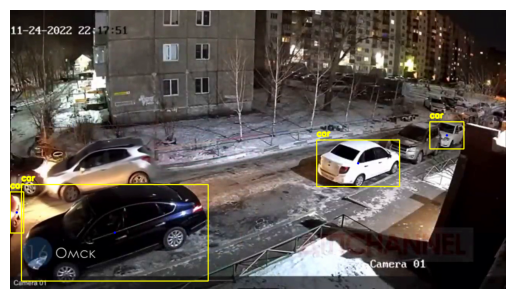

In [140]:
import json
import cv2
import matplotlib.pyplot as plt

def load_json_annotations(json_path):
    with open(json_path, 'r') as f:
        data = json.load(f)
    data = fill_missing_frames(data)
    return data

def draw_bounding_boxes(frame, boxes, labels, frame_width, frame_height):
    for box, label in zip(boxes, labels):
        # Scale the coordinates as specified
        x = int(box['x'] * 12.75)
        y = int(box['y'] * 7.3)
        w = int(box['width'] * 12.9)
        h = int(box['height'] * 6.7)

        print(f"Label: {label}, Coordinates: x={x}, y={y}, w={w}, h={h}, Frame Width: {frame_width}, Frame Height: {frame_height}")

        # Check if the box falls within frame bounds
        if x < 0 or y < 0 or x + w > frame_width or y + h > frame_height:
            print(f"Bounding box for {label} is out of bounds and will not be drawn.")
            continue

        # Draw the bounding box
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 255), 2)
        # Draw the center point of the bounding box
        center_x, center_y = x + w // 2, y + h // 2
        cv2.circle(frame, (center_x, center_y), 3, (255, 0, 0), -1)  # Blue center point for reference
        # Put the label text
        cv2.putText(frame, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 3)
    return frame

def show_frame_with_boxes(video_path, json_path, frame_number=1):
    # Load JSON annotation data
    annotations = load_json_annotations(json_path)

    # Find the specific video data and bounding boxes
    for item in annotations:
        if item['video'] in video_path:
            boxes_info = item['box']
            break
    else:
        print("No matching video data found.")
        return

    # Multiply the frame number by 2 to account for the discrepancy
    target_frame_number = frame_number * 2
    print(f"Target frame (adjusted for doubled frame count): {target_frame_number}")

    # Load the video and retrieve the specific frame
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, target_frame_number - 1)
    ret, frame = cap.read()

    if not ret:
        print("Error reading frame.")
        cap.release()
        return

    # Get frame dimensions
    frame_height, frame_width = frame.shape[:2]
    print(f"Frame dimensions: Width={frame_width}, Height={frame_height}")

    # Draw bounding boxes for objects detected in the chosen frame
    for obj in boxes_info:
        for seq in obj['sequence']:
            if seq['frame'] == frame_number:  # Match with original frame number in JSON
                frame = draw_bounding_boxes(frame, [seq], obj['labels'], frame_width, frame_height)

    # Convert BGR to RGB for display with matplotlib
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    plt.imshow(frame)
    plt.axis('off')
    plt.show()
    cap.release()

# Example usage
video_path = '/kaggle/input/car-crash-dataset-russia-2022-2023/dataset/video/w10_10.mp4'
json_path = '/kaggle/input/car-crash-dataset-russia-2022-2023/dataset/label/json/w10_10.json'
video_path = '/content/car-crash-dataset-russia-2022-2023/dataset/video/w7_4.mp4'
json_path = '/content/car-crash-dataset-russia-2022-2023/dataset/label/json/w7_4.json'
show_frame_with_boxes(video_path, json_path, frame_number=54)


In [141]:
import json
import os
from collections import defaultdict

def count_short_sequences_and_classes(json_folder_path):
    video_counter = 0  # Number of videos with objects having fewer than 10 frames
    total_short_objects = 0  # Total number of objects with fewer than 10 frames
    total_long_objects = 0  # Total number of objects with 10 or more frames
    all_short_objects_video_counter = 0  # Number of videos where all objects have fewer than 10 frames
    unique_classes = set()  # Set to store unique object classes
    class_counts = defaultdict(int)  # Dictionary to count each class label
    no_label_objects = 0
    num_videos = 0

    # Iterate over each JSON file in the folder
    for json_file in os.listdir(json_folder_path):
        if json_file.endswith('.json'):
            num_videos += 1
            json_path = os.path.join(json_folder_path, json_file)

            # Load JSON annotation data
            with open(json_path, 'r') as f:
                data = json.load(f)

            short_object_found_in_video = False  # Flag to count videos with any short objects
            all_short = True  # Assume all objects are short initially

            # Check each detected object in the JSON file
            for item in data:
                video_name = item.get('video', 'Unknown video')
                for obj in item['box']:
                    num_frames = len(obj['sequence'])  # Number of frames in this object's sequence

                    # Add the object's label to the unique_classes set and update class_counts
                    if 'labels' in obj:
                        for label in obj['labels']:
                            unique_classes.add(label)
                            class_counts[label] += 1  # Increment count for this label
                    else:
                        no_label_objects += 1

                    if num_frames < 10:
                        total_short_objects += 1
                        short_object_found_in_video = True
                    else:
                        total_long_objects += 1
                        all_short = False

            # If we found at least one short object in this video, increment video counter
            if short_object_found_in_video:
                video_counter += 1

            # If all objects in this video are short, increment the all_short counter
            if all_short:
                all_short_objects_video_counter += 1

    # Print summary
    print(f"\nSummary:")
    print(f"Total number of videos: {num_videos}")
    print(f"Total number of videos with objects having fewer than 10 frames: {video_counter}")
    print(f"Total number of objects with fewer than 10 frames: {total_short_objects}")
    print(f"Total number of objects with 10 or more frames: {total_long_objects}")
    print(f"Total number of videos where all objects have fewer than 10 frames: {all_short_objects_video_counter}")
    print(f"nc: {len(unique_classes)}")
    print(f"names: {list(unique_classes)}")
    print(f"No label objects: {no_label_objects}")

    print("\nClass counts:")
    for label, count in class_counts.items():
        print(f"{label}: {count}")

# Example usage
json_folder_path = '/kaggle/input/car-crash-dataset-russia-2022-2023/dataset/label/json'
json_folder_path = '/content/car-crash-dataset-russia-2022-2023/dataset/label/json'
count_short_sequences_and_classes(json_folder_path)


Summary:
Total number of videos: 548
Total number of videos with objects having fewer than 10 frames: 456
Total number of objects with fewer than 10 frames: 3095
Total number of objects with 10 or more frames: 2787
Total number of videos where all objects have fewer than 10 frames: 48
nc: 31
names: ['animal', 'trailer', 'traffic sign', 'object', 'Bus', 'traffic controller', 'crashed truck', 'crowd', 'group of pedestrians', 'traffic light', 'truck', 'crashed bus', 'car', 'crashed motorcycle', 'crashed car', 'ambulance', 'train', 'tram', 'crosswalk', 'tractor', 'group of cars', 'Car', 'Crosswalk', 'obstruction', 'bicycle', 'bus', 'deliveryman', 'pedestrian', 'a vehicle', 'rider', 'motorcycle']
No label objects: 1

Class counts:
car: 2657
crashed car: 695
group of cars: 165
bus: 68
crosswalk: 124
traffic sign: 1318
traffic light: 341
pedestrian: 169
motorcycle: 4
truck: 164
Car: 129
animal: 8
trailer: 1
rider: 5
group of pedestrians: 3
Bus: 4
Crosswalk: 1
object: 1
obstruction: 1
tractor

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns

class_counts = {
    'traffic sign': 1318, 'bus': 68, 'crowd': 2, 'Bus': 4, 'rider': 5,
    'tram': 3, 'trailer': 1, 'truck': 164, 'crashed truck': 1, 'obstruction': 1,
    'car': 2657, 'motorcycle': 4, 'a vehicle': 1, 'group of cars': 165,
    'crosswalk': 124, 'traffic light': 341, 'deliveryman': 1, 'animal': 8,
    'bicycle': 6, 'traffic controller': 1, 'pedestrian': 169, 'tractor': 2,
    'ambulance': 1, 'Crosswalk': 1, 'crashed car': 695, 'object': 1,
    'train': 2, 'Car': 129, 'group of pedestrians': 3, 'crashed motorcycle': 1,
    'crashed bus': 2
}
total_short_objects = 3095
total_long_objects = 2787
video_counter = 456
num_videos = 548
all_short_objects_video_counter = 48

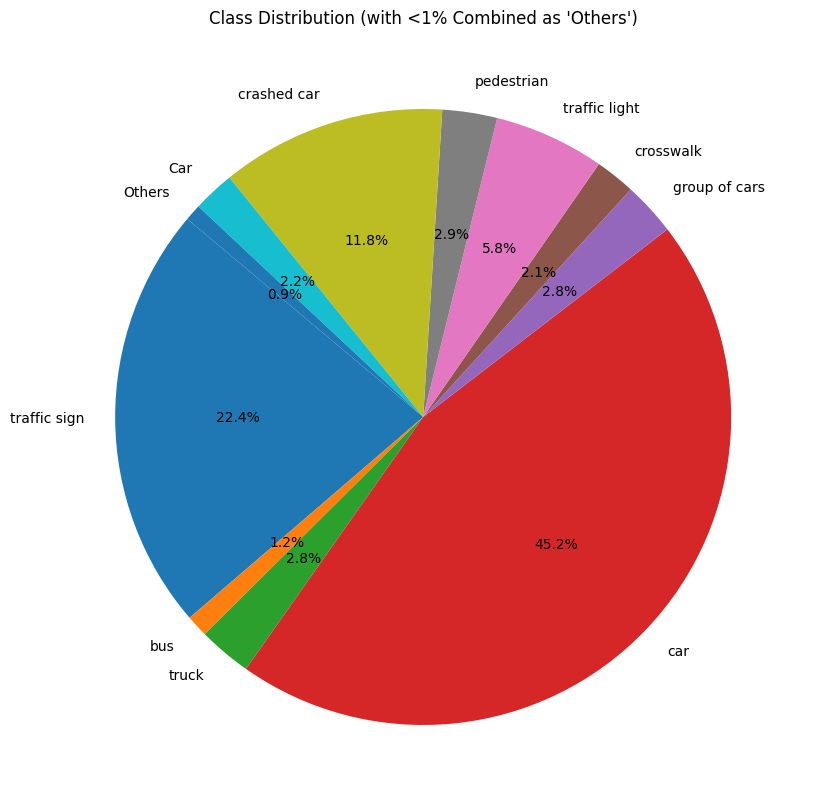

In [70]:
import matplotlib.pyplot as plt

# Define threshold for "Others" category (1% of total count)
threshold = sum(class_counts.values()) * 0.01

# Separate classes into "Others" if their count is below the threshold
main_classes = {label: count for label, count in class_counts.items() if count >= threshold}
others_count = sum(count for count in class_counts.values() if count < threshold)

# Add "Others" to the main_classes dictionary
main_classes["Others"] = others_count

# Plot the pie chart
plt.figure(figsize=(10, 10))
plt.pie(main_classes.values(), labels=main_classes.keys(), autopct='%1.1f%%', startangle=140)
plt.title("Class Distribution (with <1% Combined as 'Others')")
plt.show()


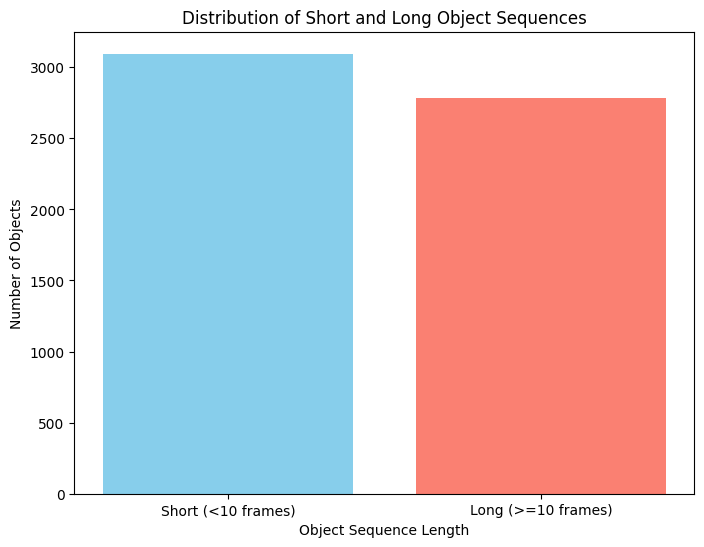

In [71]:
frame_lengths = ["Short (<10 frames)", "Long (>=10 frames)"]
frame_counts = [total_short_objects, total_long_objects]

plt.figure(figsize=(8, 6))
plt.bar(frame_lengths, frame_counts, color=["skyblue", "salmon"])
plt.xlabel("Object Sequence Length")
plt.ylabel("Number of Objects")
plt.title("Distribution of Short and Long Object Sequences")
plt.show()


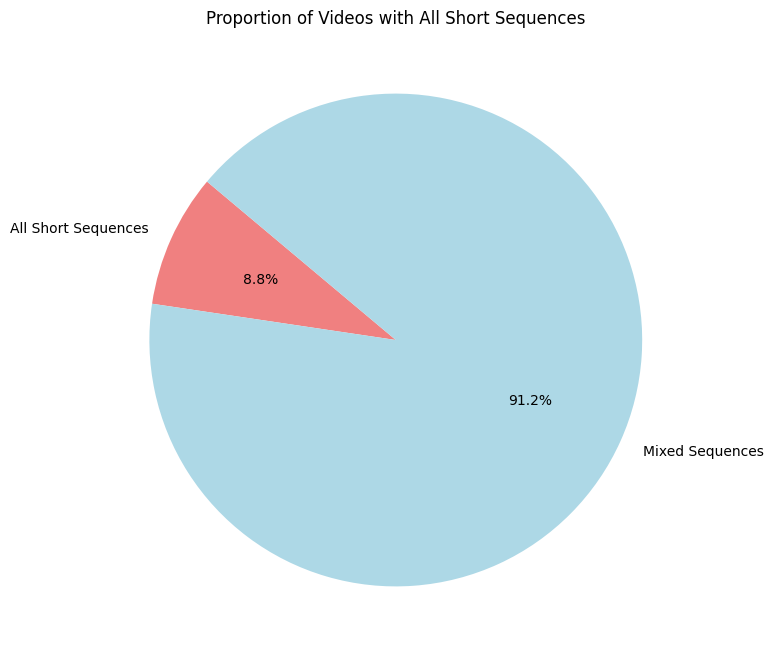

In [72]:
video_categories = ['All Short Sequences', 'Mixed Sequences']
video_counts = [all_short_objects_video_counter, num_videos - all_short_objects_video_counter]

plt.figure(figsize=(8, 8))
plt.pie(video_counts, labels=video_categories, autopct='%1.1f%%', startangle=140, colors=['lightcoral', 'lightblue'])
plt.title("Proportion of Videos with All Short Sequences")
plt.show()


In [142]:
import json
import os
import shutil

def clean_json_and_csv_data(json_folder_path, csv_folder_path, cleaned_json_folder_path, cleaned_csv_folder_path):
    # Create cleaned folders if they don't exist
    os.makedirs(cleaned_json_folder_path, exist_ok=True)
    os.makedirs(cleaned_csv_folder_path, exist_ok=True)

    # Iterate over each JSON file in the folder
    for json_file in os.listdir(json_folder_path):
        if json_file.endswith('.json'):
            json_path = os.path.join(json_folder_path, json_file)
            csv_file = json_file.replace('.json', '.csv')  # Corresponding CSV file name
            csv_path = os.path.join(csv_folder_path, csv_file)

            # Load JSON annotation data
            with open(json_path, 'r') as f:
                data = json.load(f)

            cleaned_data = []  # Store cleaned annotations
            all_objects_short = True  # Flag to check if all objects are short

            for item in data:
                # For each object in the video, filter out short sequences and those without labels
                cleaned_boxes = []

                for obj in item['box']:
                    num_frames = len(obj['sequence'])

                    # Check if the object has a label and at least 10 frames
                    if num_frames >= 10 and 'labels' in obj and obj['labels']:
                        cleaned_boxes.append(obj)  # Add to cleaned list
                        all_objects_short = False

                # Only add video entry if there are any cleaned objects left
                if cleaned_boxes:
                    item['box'] = cleaned_boxes
                    cleaned_data.append(item)

            # If all objects in the video are short, skip copying this video and its CSV file
            if all_objects_short:
                print(f"Excluding video: {json_file} (all objects have fewer than 10 frames)")
                continue

            # Save the cleaned data to the new folder
            cleaned_json_path = os.path.join(cleaned_json_folder_path, json_file)
            with open(cleaned_json_path, 'w') as f:
                json.dump(cleaned_data, f, indent=4)

            # Copy the corresponding CSV file to the cleaned folder if it exists
            if os.path.exists(csv_path):
                shutil.copy(csv_path, cleaned_csv_folder_path)

# Example usage
json_folder_path = '/kaggle/input/car-crash-dataset-russia-2022-2023/dataset/label/json'
csv_folder_path = '/kaggle/input/car-crash-dataset-russia-2022-2023/dataset/label/csv'
cleaned_json_folder_path = '/kaggle/working/car-crash-dataset-russia-2022-2023/dataset/label/json'
cleaned_csv_folder_path = '/kaggle/working/car-crash-dataset-russia-2022-2023/dataset/label/csv'

# Example usage
json_folder_path = '/content/car-crash-dataset-russia-2022-2023/dataset/label/json'
csv_folder_path = '/content/car-crash-dataset-russia-2022-2023/dataset/label/csv'
cleaned_json_folder_path = '/content/car-crash-dataset-russia-2022-2023/dataset/label/json_cleaned'
cleaned_csv_folder_path = '/content/car-crash-dataset-russia-2022-2023/dataset/label/csv_cleaned'


clean_json_and_csv_data(json_folder_path, csv_folder_path, cleaned_json_folder_path, cleaned_csv_folder_path)

Excluding video: w10_119.json (all objects have fewer than 10 frames)
Excluding video: w10_81.json (all objects have fewer than 10 frames)
Excluding video: w10_74.json (all objects have fewer than 10 frames)
Excluding video: w6_33.json (all objects have fewer than 10 frames)
Excluding video: w10_69.json (all objects have fewer than 10 frames)
Excluding video: w1_40.json (all objects have fewer than 10 frames)
Excluding video: w10_71.json (all objects have fewer than 10 frames)
Excluding video: w10_60.json (all objects have fewer than 10 frames)
Excluding video: w10_136.json (all objects have fewer than 10 frames)
Excluding video: w10_125.json (all objects have fewer than 10 frames)
Excluding video: w10_82.json (all objects have fewer than 10 frames)
Excluding video: w10_131.json (all objects have fewer than 10 frames)
Excluding video: w2_3.json (all objects have fewer than 10 frames)
Excluding video: w2_65.json (all objects have fewer than 10 frames)
Excluding video: w10_65.json (all o

In [143]:
json_folder_path = '/kaggle/working/car-crash-dataset-russia-2022-2023/dataset/label/json'
json_folder_path = '/content/car-crash-dataset-russia-2022-2023/dataset/label/json_cleaned'

count_short_sequences_and_classes(json_folder_path)


Summary:
Total number of videos: 500
Total number of videos with objects having fewer than 10 frames: 0
Total number of objects with fewer than 10 frames: 0
Total number of objects with 10 or more frames: 2786
Total number of videos where all objects have fewer than 10 frames: 0
nc: 27
names: ['animal', 'trailer', 'traffic sign', 'object', 'Bus', 'traffic controller', 'crashed truck', 'crowd', 'truck', 'traffic light', 'crashed bus', 'car', 'crashed motorcycle', 'crashed car', 'tram', 'train', 'crosswalk', 'tractor', 'group of cars', 'Car', 'bicycle', 'bus', 'deliveryman', 'pedestrian', 'a vehicle', 'rider', 'motorcycle']
No label objects: 0

Class counts:
car: 1236
crashed car: 502
group of cars: 54
bus: 31
traffic sign: 536
truck: 82
traffic light: 133
pedestrian: 70
Car: 96
crosswalk: 18
trailer: 1
Bus: 3
motorcycle: 3
object: 1
rider: 2
tractor: 2
bicycle: 2
a vehicle: 1
tram: 2
train: 1
crashed bus: 2
deliveryman: 1
animal: 3
crowd: 1
crashed motorcycle: 1
traffic controller: 1
c

In [144]:
import json
import os

# Define label mappings for the classes we want to retain
label_mappings = {
    "car": "car",
    "Car": "car",
    "truck": "car",
    "bus": "car",
    "Bus": "car",
    "tram": "car",
    "a vehicle": "car",
    "crashed car": "crashed",
    "crashed motorcycle": "crashed",
    "crashed bus": "crashed",
    "crashed truck": "crashed"
}

def clean_and_count_classes(json_folder_path, output_folder_path):
    # Create the output folder if it doesn't exist
    os.makedirs(output_folder_path, exist_ok=True)

    # Dictionary to count each class label
    class_counts = {"car": 0, "crashed": 0}

    # Iterate over each JSON file in the folder
    for json_file in os.listdir(json_folder_path):
        if json_file.endswith('.json'):
            json_path = os.path.join(json_folder_path, json_file)

            # Load JSON annotation data
            with open(json_path, 'r') as f:
                data = json.load(f)

            # Cleaned data to store only valid objects
            cleaned_data = []

            # Process each video in the JSON data
            for item in data:
                cleaned_boxes = []

                # Filter the "box" list to retain only desired classes
                for obj in item['box']:
                    valid_labels = []

                    # Map labels according to the specified mappings and filter
                    for label in obj.get('labels', []):
                        if label in label_mappings:
                            mapped_label = label_mappings[label]
                            valid_labels.append(mapped_label)
                            class_counts[mapped_label] += 1

                    # Keep the object only if it has a valid label
                    if valid_labels:
                        obj['labels'] = valid_labels
                        cleaned_boxes.append(obj)

                # Add cleaned objects to the item
                item['box'] = cleaned_boxes
                cleaned_data.append(item)

            # Save the cleaned data to the new folder
            cleaned_json_path = os.path.join(output_folder_path, json_file)
            with open(cleaned_json_path, 'w') as f:
                json.dump(cleaned_data, f, indent=4)

# Example usage
json_folder_path = '/kaggle/working/car-crash-dataset-russia-2022-2023/dataset/label/json'
output_folder_path = '/kaggle/working/car-crash-dataset-russia-2022-2023/dataset/label/json'
json_folder_path = '/content/car-crash-dataset-russia-2022-2023/dataset/label/json'
output_folder_path = '/content/car-crash-dataset-russia-2022-2023/dataset/label/json'
clean_and_count_classes(json_folder_path, output_folder_path)

In [145]:
json_folder_path = '/kaggle/working/car-crash-dataset-russia-2022-2023/dataset/label/json'
json_folder_path = '/content/car-crash-dataset-russia-2022-2023/dataset/label/json'
count_short_sequences_and_classes(json_folder_path)


Summary:
Total number of videos: 548
Total number of videos with objects having fewer than 10 frames: 418
Total number of objects with fewer than 10 frames: 1768
Total number of objects with 10 or more frames: 1957
Total number of videos where all objects have fewer than 10 frames: 51
nc: 2
names: ['crashed', 'car']
No label objects: 0

Class counts:
car: 3026
crashed: 699


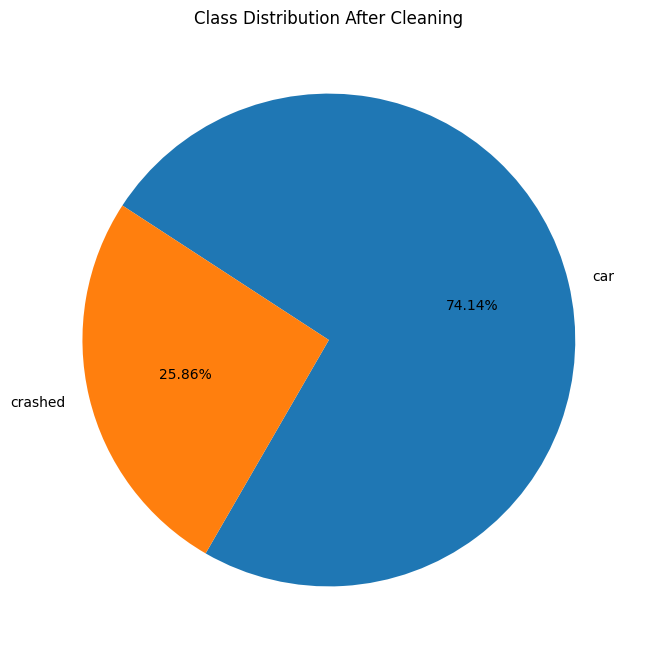

In [77]:
import matplotlib.pyplot as plt

# Data for the cleaned class counts
class_counts = {
    "car": 1451,
    "crashed": 506
}

# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(class_counts.values(), labels=class_counts.keys(), autopct='%1.2f%%', startangle=240)
plt.title("Class Distribution After Cleaning")
plt.show()


In [78]:
# import shutil
# import os

# def delete_folder_contents_and_folder(folder_path):
#     # Check if the folder exists
#     if os.path.exists(folder_path) and os.path.isdir(folder_path):
#         # Remove all contents of the folder
#         shutil.rmtree(folder_path)
#         print(f"Deleted all contents and the folder: {folder_path}")
#     else:
#         print(f"Folder does not exist: {folder_path}")

# # Example usage
# folder_path = '/kaggle/working/car-crash-dataset-russia-2022-2023/dataset/label/json'
# delete_folder_contents_and_folder(folder_path)

Target frame (adjusted for doubled frame count): 80
Frame dimensions: Width=1280, Height=720
Label: crashed, Coordinates: x=221, y=337, w=142, h=70, Frame Width: 1280, Frame Height: 720
Label: car, Coordinates: x=156, y=327, w=128, h=54, Frame Width: 1280, Frame Height: 720
Label: car, Coordinates: x=98, y=323, w=61, h=27, Frame Width: 1280, Frame Height: 720
Label: car, Coordinates: x=57, y=324, w=81, h=34, Frame Width: 1280, Frame Height: 720
Label: car, Coordinates: x=1063, y=322, w=171, h=73, Frame Width: 1280, Frame Height: 720
Label: car, Coordinates: x=291, y=320, w=66, h=31, Frame Width: 1280, Frame Height: 720
Label: car, Coordinates: x=500, y=331, w=110, h=42, Frame Width: 1280, Frame Height: 720
Label: car, Coordinates: x=266, y=337, w=92, h=31, Frame Width: 1280, Frame Height: 720
Label: car, Coordinates: x=909, y=341, w=94, h=47, Frame Width: 1280, Frame Height: 720


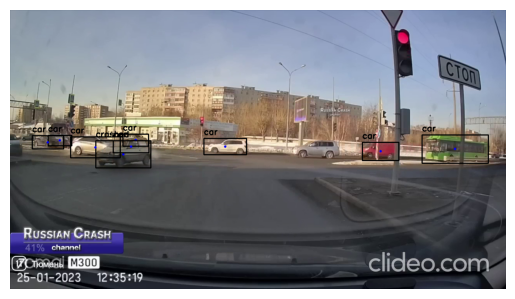

In [146]:
import json
import cv2
import matplotlib.pyplot as plt

def load_json_annotations(json_path):
    with open(json_path, 'r') as f:
        data = json.load(f)
    return data

def draw_bounding_boxes(frame, boxes, labels, frame_width, frame_height):
    for box, label in zip(boxes, labels):
        # Scale the coordinates as specified
        x = int(box['x'] * 12.75)
        y = int(box['y'] * 7.3)
        w = int(box['width'] * 12.9)
        h = int(box['height'] * 6.7)

        print(f"Label: {label}, Coordinates: x={x}, y={y}, w={w}, h={h}, Frame Width: {frame_width}, Frame Height: {frame_height}")

        # Check if the box falls within frame bounds
        if x < 0 or y < 0 or x + w > frame_width or y + h > frame_height:
            print(f"Bounding box for {label} is out of bounds and will not be drawn.")
            continue

        # Draw the bounding box
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 0, 0), 2)
        # Draw the center point of the bounding box
        center_x, center_y = x + w // 2, y + h // 2
        cv2.circle(frame, (center_x, center_y), 3, (255, 0, 0), -1)  # Blue center point for reference
        # Put the label text
        cv2.putText(frame, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2)
    return frame

def show_frame_with_boxes(video_path, json_path, frame_number=1):
    # Load JSON annotation data
    annotations = load_json_annotations(json_path)

    # Find the specific video data and bounding boxes
    for item in annotations:
        if item['video'] in video_path:
            boxes_info = item['box']
            break
    else:
        print("No matching video data found.")
        return

    # Multiply the frame number by 2 to account for the discrepancy
    target_frame_number = frame_number * 2
    print(f"Target frame (adjusted for doubled frame count): {target_frame_number}")

    # Load the video and retrieve the specific frame
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, target_frame_number - 1)
    ret, frame = cap.read()

    if not ret:
        print("Error reading frame.")
        cap.release()
        return

    # Get frame dimensions
    frame_height, frame_width = frame.shape[:2]
    print(f"Frame dimensions: Width={frame_width}, Height={frame_height}")

    # Draw bounding boxes for objects detected in the chosen frame
    for obj in boxes_info:
        for seq in obj['sequence']:
            if seq['frame'] == frame_number:  # Match with original frame number in JSON
                frame = draw_bounding_boxes(frame, [seq], obj['labels'], frame_width, frame_height)

    # Convert BGR to RGB for display with matplotlib
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    plt.imshow(frame)
    plt.axis('off')
    plt.show()
    cap.release()

# Example usage
video_path = '/kaggle/input/car-crash-dataset-russia-2022-2023/dataset/video/w10_10.mp4'
json_path = '/kaggle/working/car-crash-dataset-russia-2022-2023/dataset/label/json/w10_10.json'
# Example usage
video_path = '/content/car-crash-dataset-russia-2022-2023/dataset/video/w10_10.mp4'
json_path = '/content/car-crash-dataset-russia-2022-2023/dataset/label/json/w10_10.json'
show_frame_with_boxes(video_path, json_path, frame_number=40)


In [147]:
import os
import json
import pandas as pd

def extract_csv_values_pandas(csv_path):
    """
    Extracts the number of rows (csv_frame_count) and the index of the first 'after crash' frame (after_crush_start) from a CSV file using pandas.

    Args:
        csv_path (str): Path to the CSV file.

    Returns:
        tuple: (csv_frame_count, after_crush_start)
    """
    # Read the CSV file
    df = pd.read_csv(csv_path)

    # Count the total number of rows
    csv_frame_count = len(df)

    # Find the index of the first 'after crash' occurrence
    after_crush_start = df[df['type'] == 'after crush'].index.min()

    if pd.isna(after_crush_start):
        raise ValueError("No 'after crash' label found in the CSV file.")

    return csv_frame_count, after_crush_start

def extract_json_frame_count(json_path):
    """
    Extracts the value of 'framesCount' from the JSON file.

    Args:
        json_path (str): Path to the JSON file.

    Returns:
        int: The value of 'framesCount' from the JSON file.
    """
    with open(json_path, 'r') as f:
        data = json.load(f)

    # Iterate over each object in the JSON
    for item in data:
        for box in item.get('box', []):
            # Extract the 'framesCount' value
            frames_count = box.get('framesCount', None)
            if frames_count is not None:
                return frames_count

    raise ValueError("'framesCount' not found in the JSON file.")

# Example Usage
json_path = '/kaggle/input/car-crash-dataset-russia-2022-2023/dataset/label/json/w10_10.json'
csv_path = '/kaggle/input/car-crash-dataset-russia-2022-2023/dataset/label/csv/w10_10.csv'

# Example Usage
json_path = '/content/car-crash-dataset-russia-2022-2023/dataset/label/json/w10_10.json'
csv_path = '/content/car-crash-dataset-russia-2022-2023/dataset/label/csv/w10_10.csv'

csv_frame_count, after_crush_start = extract_csv_values_pandas(csv_path)
json_frame_count = extract_json_frame_count(json_path)

# Print results
print(f"CSV Frame Count: {csv_frame_count}")
print(f"After Crush Start (CSV): {after_crush_start}")
print(f"JSON Frame Count: {json_frame_count}")

CSV Frame Count: 175
After Crush Start (CSV): 87
JSON Frame Count: 108


In [148]:
def map_csv_to_json_frames(csv_frame_count, json_frame_count, after_crush_start):
    """
    Map the 'after crush' frame index from the CSV file to the corresponding JSON frame index.

    Args:
        csv_frame_count (int): Number of frames in the CSV file.
        json_frame_count (int): Number of frames in the JSON file.
        after_crush_frame (int): Frame index for 'after crush' in the CSV file.

    Returns:
        int: Mapped frame index for 'after crush' in the JSON file.
    """
    ratio = json_frame_count / csv_frame_count
    json_after_crush_frame = max(0, int(after_crush_start * ratio))  # Ensure no negative frame indices
    return json_after_crush_frame

print(map_csv_to_json_frames(csv_frame_count, json_frame_count, after_crush_start))

53


In [149]:
import json
import os

def count_crashed_car_labels(json_folder):
    """
    Count the number of `crashed_car` labels in all JSON files within a folder.

    Args:
        json_folder (str): Path to the folder containing JSON files.

    Returns:
        dict: Dictionary with file names as keys and counts of `crashed_car` as values.
    """
    crashed_car_counts = {}

    # Iterate over all JSON files in the folder
    for json_file in os.listdir(json_folder):
        if json_file.endswith('.json'):
            json_path = os.path.join(json_folder, json_file)
            with open(json_path, 'r') as f:
                data = json.load(f)

            count = 0
            for item in data:  # Loop through video data
                for obj in item.get('box', []):  # Loop through detected objects
                    if 'crashed' in obj.get('labels', []):  # Check for `crashed_car`
                        count += 1

            crashed_car_counts[json_file] = count

    return crashed_car_counts

# Example usage
json_folder = '/kaggle/working/car-crash-dataset-russia-2022-2023/dataset/label/json'
json_folder = '/content/car-crash-dataset-russia-2022-2023/dataset/label/json'
crashed_car_counts = count_crashed_car_labels(json_folder)

# for file_name, count in crashed_car_counts.items():
#     print(f"{file_name}: {count} `crashed_car` labels")

from collections import Counter

def count_videos_by_crashed_car_labels(crashed_car_counts):
    """
    Count how many videos have a specific number of `crashed_car` labels.

    Args:
        crashed_car_counts (dict): Dictionary with file names as keys and counts of `crashed_car` as values.

    Returns:
        dict: Dictionary where keys are the number of `crashed_car` labels and values are counts of videos.
    """
    # Use Counter to count occurrences of each number of `crashed_car` labels
    label_distribution = Counter(crashed_car_counts.values())

    return label_distribution

# Count videos by the number of `crashed_car` labels
label_distribution = count_videos_by_crashed_car_labels(crashed_car_counts)

# Print the results
for label_count, video_count in sorted(label_distribution.items()):
    print(f"{video_count} videos have {label_count} `crashed` labels")

155 videos have 0 `crashed` labels
125 videos have 1 `crashed` labels
237 videos have 2 `crashed` labels
26 videos have 3 `crashed` labels
4 videos have 4 `crashed` labels
1 videos have 6 `crashed` labels


In [150]:
def get_videos_with_specific_crashed_car_count(crashed_car_counts, target_count):
    """
    Find the video names that have a specific number of `crashed_car` labels.

    Args:
        crashed_car_counts (dict): Dictionary with file names as keys and counts of `crashed_car` as values.
        target_count (int): The target number of `crashed_car` labels to filter by.

    Returns:
        list: List of video names with the specific count of `crashed_car` labels.
    """
    # Filter dictionary to find video names with the target number of `crashed_car` labels
    return [video for video, count in crashed_car_counts.items() if count == target_count]

# Target number of crashed cars to search for
target_count = 4

# Get video names with exactly 4 crashed cars
videos_with_target_count = get_videos_with_specific_crashed_car_count(crashed_car_counts, target_count)

# Print the results
if videos_with_target_count:
    print(f"Videos with {target_count} `crashed_car` labels:")
    for video in videos_with_target_count:
        print(video)
else:
    print(f"No videos found with {target_count} `crashed_car` labels.")


Videos with 4 `crashed_car` labels:
w3_3.json
w2_74.json
w5_46.json
w2_72.json


In [151]:
import json
from collections import Counter

def count_labels_in_videos(json_path):
    """
    Count the labels (classes) and their occurrences in each video.

    Args:
        json_path (str): Path to the JSON file containing the annotation data.

    Returns:
        dict: A dictionary where each key is the video name, and the value is another dictionary
              with class labels as keys and their counts as values.
    """
    # Load JSON annotation data
    with open(json_path, 'r') as f:
        data = json.load(f)

    video_label_counts = {}

    for item in data:
        video_name = item['video']
        labels = []

        for obj in item['box']:
            labels.extend(obj['labels'])  # Collect all labels from this video's objects

        # Count the occurrences of each label
        label_count = dict(Counter(labels))
        video_label_counts[video_name] = label_count

    return video_label_counts


def print_label_counts(video_label_counts):
    """
    Print the label counts for each video.

    Args:
        video_label_counts (dict): A dictionary where each key is the video name,
                                   and the value is a dictionary of label counts.
    """
    for video, label_counts in video_label_counts.items():
        print(f"Video: {video}")
        for label, count in label_counts.items():
            print(f"  {label}: {count}")
        print()


# Example usage
json_path = '/kaggle/working/car-crash-dataset-russia-2022-2023/dataset/label/json/w5_3.json'
json_path = '/content/car-crash-dataset-russia-2022-2023/dataset/label/json/w5_3.json'
video_label_counts = count_labels_in_videos(json_path)
print_label_counts(video_label_counts)


Video: w5_3.mp4
  car: 7



Target frame (adjusted for doubled frame count): 288
Frame dimensions: Width=1280, Height=720
Label: car, Coordinates: x=141, y=256, w=370, h=318, Frame Width: 1280, Frame Height: 720
Label: car, Coordinates: x=489, y=459, w=85, h=62, Frame Width: 1280, Frame Height: 720
Label: car, Coordinates: x=503, y=447, w=30, h=36, Frame Width: 1280, Frame Height: 720


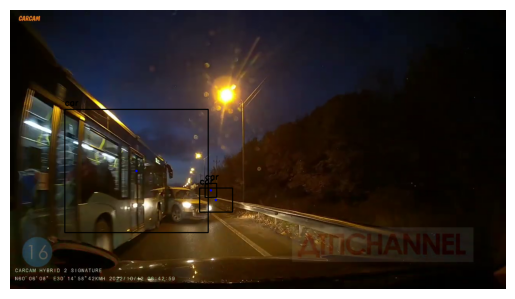

In [152]:
# Example usage
video_path = '/kaggle/input/car-crash-dataset-russia-2022-2023/dataset/video/w5_3.mp4'
json_path = '/kaggle/input/car-crash-dataset-russia-2022-2023/dataset/label/json/w5_3.json'
video_path = '/content/car-crash-dataset-russia-2022-2023/dataset/video/w5_3.mp4'
json_path = '/content/car-crash-dataset-russia-2022-2023/dataset/label/json/w5_3.json'
show_frame_with_boxes(video_path, json_path, frame_number=144)

In [153]:
# Clone the YOLO repository
!git clone https://github.com/ultralytics/yolov5.git

# Install required dependencies
!pip install -r /kaggle/working/yolov5/requirements.txt
!pip install -r /content/yolov5/requirements.txt

fatal: destination path 'yolov5' already exists and is not an empty directory.
ERROR: Could not open requirements file: [Errno 2] No such file or directory: '/kaggle/working/yolov5/requirements.txt'


In [ ]:
import shutil

source_dir = "/kaggle/input/car-crash-dataset-russia-2022-2023/dataset/video"
# source_dir = "/content/car-crash-dataset-russia-2022-2023/dataset/video"

destination_dir = "/kaggle/working/video"

shutil.copytree(source_dir, destination_dir, dirs_exist_ok=True)

'/kaggle/working/video'

In [154]:
import os

def create_directory(directory):
    try:
        # Create the directory
        os.makedirs(directory, exist_ok=True)  # exist_ok=True prevents an error if the directory already exists
        print(f"Directory '{directory}' created successfully.")
    except Exception as e:
        print(f"An error occurred while creating the directory: {e}")


# create_directory("/kaggle/working/dataset/validate/images")
# create_directory("/kaggle/working/dataset/train/images")
create_directory("/content/car-crash-dataset-russia-2022-2023/dataset/validate/images")
create_directory("/content/car-crash-dataset-russia-2022-2023/dataset/train/images")

Directory '/content/car-crash-dataset-russia-2022-2023/dataset/validate/images' created successfully.
Directory '/content/car-crash-dataset-russia-2022-2023/dataset/train/images' created successfully.


In [155]:
import os
import json
import cv2
from pathlib import Path
import random

# Paths to the directories
VIDEO_DIRECTORY = "/kaggle/working/video"
JSON_DIRECTORY = "/kaggle/working/car-crash-dataset-russia-2022-2023/dataset/label/json"
TRAIN_IMAGES_DIR = "/kaggle/working/dataset2/images/train/"
VALIDATE_IMAGES_DIR = "/kaggle/working/dataset2/images/validate/"


VIDEO_DIRECTORY = "/content/car-crash-dataset-russia-2022-2023/dataset/video"
JSON_DIRECTORY = "/content/car-crash-dataset-russia-2022-2023/dataset/label/json"
TRAIN_IMAGES_DIR = "/content/dataset2/images/train/"
VALIDATE_IMAGES_DIR = "/content/dataset2/images/validate/"

# Function to create directories if they don't exist
def create_directory(directory):
    os.makedirs(directory, exist_ok=True)

# Ensure directories exist
create_directory(TRAIN_IMAGES_DIR)
create_directory(VALIDATE_IMAGES_DIR)

def get_json_files(directory):
    return sorted(Path(directory).glob('*.json'))  # Get and sort JSON files

def extract_frames_count_from_json(json_path):
    try:
        with open(json_path, 'r') as json_file:
            data = json.load(json_file)
            for item in data:
                if 'box' in item and item['box']:
                    frames_count = item['box'][0].get('framesCount', None)
                    if frames_count is not None:
                        return frames_count
            print(f"No 'framesCount' found in {json_path}")
            return None
    except Exception as e:
        print(f"Error reading {json_path}: {e}")
        return None

def collect_frames_counts(json_directory):
    frames_counts = {}
    json_files = get_json_files(json_directory)
    for json_file in json_files:
        frames_count = extract_frames_count_from_json(json_file)
        if frames_count is not None:
            key = json_file.stem
            frames_counts[key] = frames_count
    return frames_counts

def get_video_files(directory):
    return sorted(Path(directory).glob('*.mp4'))  # Adjust the extension if needed

def split_video_to_frames(video_path, output_folder, num_frames):
    # Create output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    video_capture = cv2.VideoCapture(str(video_path))
    total_frames = int(video_capture.get(cv2.CAP_PROP_FRAME_COUNT))
    interval = max(total_frames // (num_frames * 2), 1)
    frames_captured = 0
    frame_number = 0
    while frames_captured < num_frames:
        video_capture.set(cv2.CAP_PROP_POS_FRAMES, frame_number * 2)
        ret, frame = video_capture.read()
        if not ret:
            break
        output_path = os.path.join(output_folder, f"{video_path.stem}_frame_{frames_captured + 1:04d}.jpg")
        cv2.imwrite(output_path, frame)
        frames_captured += 1
        frame_number += 1
    video_capture.release()
    print(f"Extracted {frames_captured} frames from {video_path.name} to {output_folder}")

def split_data(video_files, validation_split=0.2, seed=42):
    random.seed(seed)
    random.shuffle(video_files)
    split_index = int(len(video_files) * (1 - validation_split))
    return video_files[:split_index], video_files[split_index:]

def process_videos(video_files, frames_counts, output_dir):
    for video_file in video_files:
        key = video_file.stem
        if key in frames_counts:
            num_frames = frames_counts[key]
            split_video_to_frames(video_file, output_dir, num_frames)
        else:
            print(f"Skipping video {video_file.name}: No corresponding JSON file found.")

# Main logic
frames_counts = collect_frames_counts(JSON_DIRECTORY)
video_files = get_video_files(VIDEO_DIRECTORY)

# Split videos into train and validation sets
train_videos, validate_videos = split_data(video_files, validation_split=0.2,seed=42)

No 'framesCount' found in /content/car-crash-dataset-russia-2022-2023/dataset/label/json/w5_40.json


In [172]:
TRAIN_IMAGES_DIR

'/content/dataset2/images/train/'

In [176]:
process_videos(train_videos[:4], frames_counts, TRAIN_IMAGES_DIR)

Extracted 105 frames from w3_51.mp4 to /content/dataset2/images/train/
Extracted 179 frames from w7_13.mp4 to /content/dataset2/images/train/
Extracted 231 frames from w2_86.mp4 to /content/dataset2/images/train/
Extracted 96 frames from w10_36.mp4 to /content/dataset2/images/train/


In [174]:
process_videos(validate_videos[:1], frames_counts, VALIDATE_IMAGES_DIR)

Extracted 56 frames from w10_82.mp4 to /content/dataset2/images/validate/


In [159]:
import os
import json
from pathlib import Path

def get_json_files(directory):
    return sorted(Path(directory).glob('*.json'))  # Get and sort JSON files

def extract_frames_count_from_json(json_path):
    try:
        with open(json_path, 'r') as json_file:
            data = json.load(json_file)
            # Navigate through the nested structure to get framesCount
            frames_count = data[0]['box'][0]['framesCount']
            return frames_count
    except (FileNotFoundError, KeyError, IndexError) as e:
        print(f"Error reading {json_path}: {e}")
        return None

def collect_frames_counts(directory):
    frames_counts = {}
    json_files = get_json_files(directory)

    for json_file in json_files:
        frames_count = extract_frames_count_from_json(json_file)
        if frames_count is not None:
            # Use the filename without extension as the key
            key = json_file.stem
            frames_counts[key] = frames_count

    return frames_counts

# Example usage
json_directory_path = "/content/car-crash-dataset-russia-2022-2023/dataset/label/json"  # Replace with your JSON directory path
frames_counts_dict = collect_frames_counts(json_directory_path)

print("Collected framesCount values:", frames_counts_dict)

Error reading /content/car-crash-dataset-russia-2022-2023/dataset/label/json/w5_40.json: list index out of range
Collected framesCount values: {'w10_10': 108, 'w10_100': 71, 'w10_101': 67, 'w10_102': 113, 'w10_103': 92, 'w10_104': 67, 'w10_105': 89, 'w10_106': 61, 'w10_107': 83, 'w10_108': 67, 'w10_109': 98, 'w10_11': 139, 'w10_110': 61, 'w10_111': 69, 'w10_112': 63, 'w10_113': 45, 'w10_114': 69, 'w10_115': 53, 'w10_116': 35, 'w10_117': 155, 'w10_118': 48, 'w10_119': 67, 'w10_12': 61, 'w10_120': 91, 'w10_121': 69, 'w10_122': 74, 'w10_123': 65, 'w10_124': 45, 'w10_125': 39, 'w10_126': 101, 'w10_127': 39, 'w10_128': 38, 'w10_129': 90, 'w10_13': 60, 'w10_130': 68, 'w10_131': 75, 'w10_132': 208, 'w10_133': 312, 'w10_134': 227, 'w10_135': 132, 'w10_136': 158, 'w10_137': 213, 'w10_138': 121, 'w10_139': 175, 'w10_14': 111, 'w10_140': 93, 'w10_141': 146, 'w10_142': 88, 'w10_143': 56, 'w10_144': 107, 'w10_145': 208, 'w10_146': 156, 'w10_147': 155, 'w10_148': 39, 'w10_149': 48, 'w10_15': 70, 'w1

In [160]:
!pip install ultralytics

In [180]:
import os
import json
from pathlib import Path
import random

def create_yolo_txt(json_files, output_folder, img_width=640, img_height=480):
    """
    Process JSON files to generate YOLO annotation files in the specified output folder.

    Args:
        json_files (list): List of JSON file paths.
        output_folder (str): Output folder to save YOLO annotation TXT files.
        img_width (int): Width of the images.
        img_height (int): Height of the images.
    """
    os.makedirs(output_folder, exist_ok=True)  # Ensure the output folder exists

    for json_path in json_files:

        json_filename = Path(json_path).name
        if json_filename not in ["w3_51.json", "w10_82.json", "w2_86.json" ,"w7_13.json", "w10_36.json"]:
          continue
        # Load the JSON data
        with open(json_path, 'r') as f:
            data = json.load(f)
        data = fill_missing_frames(data)
        # Extract the sequence from the box
        sequences = data[0].get('box', [])
        for box in sequences:
            frames = box.get('sequence', [])
            # print(frames)
            # print(len(frames))
            for frame in frames:
                frame_id = frame.get('frame', -1)
                x = frame.get('x', 0)
                y = frame.get('y', 0)
                width = frame.get('width', 0)
                height = frame.get('height', 0)

                # Create a TXT file for each frame
                # txt_filename = f"{Path(json_filename).stem}_frame_{frame_id}.txt"
                txt_filename = f"{Path(json_filename).stem}_frame_{str(frame_id).zfill(4)}.txt"

                txt_path = os.path.join(output_folder, txt_filename)

                # Normalize the bounding box coordinates to [0, 1]
                x_center = x + (width / 2)
                y_center = y + (height / 2)

                # Normalize the center coordinates and dimensions
                x_center /= img_width
                y_center /= img_height
                width /= img_width
                height /= img_height

                # Write to the TXT file in YOLO format (class_id 0 assumed here)
                with open(txt_path, 'w') as txt_file:
                    txt_file.write(f"0 {x_center} {y_center} {width} {height}\n")

        print(f"Processed annotations for {json_filename}")

def split_data(json_files, validation_split=0.2, seed=42):
    """
    Split JSON files into training and validation sets using a fixed seed.

    Args:
        json_files (list): List of JSON file paths.
        validation_split (float): Ratio of validation data.
        seed (int): Random seed for reproducibility.

    Returns:
        tuple: Two lists of JSON file paths (train, validate).
    """
    random.seed(seed)  # Fix the random seed
    random.shuffle(json_files)  # Shuffle the data
    split_index = int(len(json_files) * (1 - validation_split))
    return json_files[:split_index], json_files[split_index:]

# Main logic
json_directory = "/kaggle/working/car-crash-dataset-russia-2022-2023/dataset/label/json"
csv_directory = "/kaggle/working/car-crash-dataset-russia-2022-2023/dataset/label/csv"


json_directory = "/content/car-crash-dataset-russia-2022-2023/dataset/label/json"
csv_directory = "/content/car-crash-dataset-russia-2022-2023/dataset/label/csv"
all_json_files = list(Path(json_directory).glob("*.json"))  # Get all JSON files
print(len(all_json_files))
# Use the same random seed as in the video splitting code
seed = 42  # Fixed seed for consistency
train_json_files, validate_json_files = split_data(all_json_files, validation_split=0.2, seed=seed)


548


In [181]:
# import os
# import shutil

# # Path to the directory you want to clear
# directory = "/content/dataset2/images/train"

# # Ensure the directory exists
# if os.path.exists(directory):
#     # Remove all files and subdirectories
#     shutil.rmtree(directory)
#     print(f"All files and subdirectories in '{directory}' have been deleted.")
#     # Recreate the empty directory if needed
#     os.makedirs(directory)
#     print(f"The directory '{directory}' has been recreated.")
# else:
#     print(f"The directory '{directory}' does not exist.")


In [182]:

print(len(validate_json_files))
# files = ["w3_51.json", "w10_82", "w2_86" ,"w7_13"]
# Process training and validation datasets1
train_labels_dir = "/kaggle/working/dataset2/labels/train/"
validate_labels_dir = "/kaggle/working/dataset2/labels/validate/"
train_labels_dir = "/content/dataset2/labels/train/"
validate_labels_dir = "/content/dataset2/labels/validate/"

create_yolo_txt(train_json_files, train_labels_dir)
create_yolo_txt(validate_json_files, validate_labels_dir)

110
Processed annotations for w3_51.json
Processed annotations for w10_82.json
Processed annotations for w2_86.json
Processed annotations for w7_13.json
Processed annotations for w10_36.json


In [192]:
create_yolo_txt(validate_json_files, validate_labels_dir)

In [183]:
# # Create .yaml file
# import yaml

# data_yaml = dict(
#     train = '/kaggle/working/train.txt',
#     val = '/kaggle/working/val.txt',
#     nc = 2,
#     names = ['Car', 'crashed'],
#     path = '/kaggle/working/dataset2'
# )

# # Note that I am creating the file in the yolov5/data/ directory.
# with open('dataset2.yaml', 'w') as outfile:
#     yaml.dump(data_yaml, outfile, default_flow_style=True)

In [184]:
import yaml

# Define the YAML content as a string
yaml_content = """

# Train/val/test sets as 1) dir: path/to/imgs, 2) file: path/to/imgs.txt, or 3) list: [path/to/imgs1, path/to/imgs2, ..]
path: /content/dataset2 # dataset root dir
train: images/train # train images (relative to 'path') 118287 images
val: images/validate # val images (relative to 'path') 5000 images

# Classes
names:
  0: Car
  1: crashed
"""

# Parse the string to a Python dictionary
data = yaml.safe_load(yaml_content)

# Write the dictionary to a .yaml file
output_file = "dataset2.yaml"
with open(output_file, "w") as file:
    yaml.dump(data, file, default_flow_style=False)

print(f"YAML file '{output_file}' created successfully.")


YAML file 'dataset2.yaml' created successfully.


In [185]:
import wandb

try:

    wandb.login(key='17ac335716fafb9a309055c54e5290dd49a68097')
    anony = None
except:
    anony = "must"
    print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')

wandb: Currently logged in as: osama-orabi-99 (osama-orabi-99-innopolis-university). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [186]:
import os

def count_files_in_folder(folder_path):
    """
    Count the number of files in a folder.

    Args:
        folder_path (str): Path to the folder.

    Returns:
        int: Number of files in the folder.
    """
    if not os.path.exists(folder_path):
        print(f"Folder does not exist: {folder_path}")
        return 0

    # Count files
    num_files = sum([1 for entry in os.scandir(folder_path) if entry.is_file()])
    return num_files, [entry.path for entry in os.scandir(folder_path) if entry.is_file()]

# Example usage
folder_path = "/kaggle/working/dataset2/images/train"  # Replace with your folder path
folder_path = "/content/dataset2/images/train"  # Replace with your folder path
file_count, files_train = count_files_in_folder(folder_path)
print(f"Number of files in '{folder_path}': {file_count}")

folder_path = "/kaggle/working/dataset2/images/validate/"  # Replace with your folder path
folder_path = "/content/dataset2/images/validate/"  # Replace with your folder path
file_count, files_validate = count_files_in_folder(folder_path)
print(f"Number of files in '{folder_path}': {file_count}")


Number of files in '/content/dataset2/images/train': 651
Number of files in '/content/dataset2/images/validate/': 56


In [187]:
# # Write file paths to .txt
# with open("/kaggle/working/train.txt", 'w') as txt_file:
#     txt_file.write("\n".join(files_train))

In [188]:
import os

def check_dir_and_count_files(dir_path):
    if os.path.exists(dir_path) and os.path.isdir(dir_path):
        # List all files in the directory
        files = [f for f in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, f))]
        print(f"Directory '{dir_path}' exists.")
        print(f"Number of files in '{dir_path}': {len(files)}")
    else:
        print(f"Directory '{dir_path}' does not exist.")

# Example usage
dir_path = '/kaggle/working/dataset2/labels/train'
dir_path = '/content/dataset2/labels/train'
check_dir_and_count_files(dir_path)


Directory '/content/dataset2/labels/train' exists.
Number of files in '/content/dataset2/labels/train': 666


In [189]:
# # YOLOv5 PyTorch HUB Inference (DetectionModels only)
# import torch

# model = torch.hub.load('/kaggle/working/yolov5/runs/train/exp20/weights/best.pt', 'yolov5s', force_reload=True, trust_repo=True)  # or yolov5n - yolov5x6 or custom
# im = 'https://ultralytics.com/images/zidane.jpg'  # file, Path, PIL.Image, OpenCV, nparray, list
# results = model(im)  # inference
# results.print()  # or .show(), .save(), .crop(), .pandas(), etc.

In [190]:
!python /kaggle/working/yolov5/detect.py --weights yolov5n.pt --source /kaggle/working/dataset2/images/validate


python3: can't open file '/kaggle/working/yolov5/detect.py': [Errno 2] No such file or directory


In [191]:
!python /content/yolov5/train.py --data /content/dataset2.yaml --weights yolov5n.pt --imgsz 416 --batch-size 16 --epochs 3 --cache


wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2024-11-24 19:20:36.910292: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-24 19:20:36.930439: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-24 19:20:36.936595: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
wandb: Currently logged in as: osama-orabi-99 (osama-orabi-99-innopolis-university). Use `wandb login --relogin` to force relogin
train: weights=yolov5n.pt, cfg=, data=/content/dataset2.yaml, hyp=yolov5/d

In [ ]:
import warnings
warnings.filterwarnings("ignore")


In [ ]:
!python /kaggle/working/yolov5/train.py --img 416 --batch 16 --epochs 50 --data /kaggle/working/dataset.yaml --weights yolov5n.pt

In [ ]:
train_videos[:10]

[PosixPath('/kaggle/working/video/w3_51.mp4'),
 PosixPath('/kaggle/working/video/w7_13.mp4'),
 PosixPath('/kaggle/working/video/w2_86.mp4'),
 PosixPath('/kaggle/working/video/w10_36.mp4'),
 PosixPath('/kaggle/working/video/w3_10.mp4'),
 PosixPath('/kaggle/working/video/w6_88.mp4'),
 PosixPath('/kaggle/working/video/w3_31.mp4'),
 PosixPath('/kaggle/working/video/w7_9.mp4'),
 PosixPath('/kaggle/working/video/w5_15.mp4'),
 PosixPath('/kaggle/working/video/w6_47.mp4')]